In [9]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import os
import random
import itertools
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.5"

jax.config.update("jax_enable_x64", True)
seed = jr.PRNGKey(0)

# Initialize parameters
ELEM_Q = 1.602e-19
BOLTZ = 1.380662e-23
EPS_0 = 8.864-12 * 1e-9
EPS_S = 11.7 * EPS_0
T = 300
KT_Q = BOLTZ * T / ELEM_Q
NI = 1e10 * 1e-21

def MLP(layers: list[int] = [1, 64, 1], activation: callable = jnp.tanh):
    def init_params(key):
        def _init(key, d_in, d_out):
            w = jr.normal(key, shape=(d_in, d_out)) * jnp.sqrt(2 / (d_in + d_out))
            b = jnp.zeros((d_out,))
            return [w, b]

        keys = jr.split(key, len(layers) - 1)
        params = list(map(_init, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = inputs @ W + b
            inputs = activation(outputs)
        W, b = params[-1]
        outputs = inputs @ W + b
        return outputs

    return init_params, apply

# pot = MLP(:, 0), n = MLP(:, 1)
key, subkey = jr.split(seed)
init_params, apply = MLP([2, 100, 100, 100, 100, 2])
params = init_params(subkey)
# with open('params_1D_Poi_Cont_test-dhseo-bak.pkl', 'rb') as f:
#     params = pickle.load(f)

@jax.jit
def pinn(params, x, Nd, Vd_vec):
    V_contact = KT_Q * jnp.log(Nsd / NI)
    # input = jnp.hstack([jnp.atleast_1d(x), jnp.atleast_1d(Vd_vec), jnp.atleast_1d(Nd)])
    input = jnp.hstack([jnp.atleast_1d(x), jnp.atleast_1d(Vd_vec)])
    pinn_temp = apply(params, input).squeeze()
    pot = pinn_temp[0]
    log_charge = jnp.log(Nsd) + x * (1-x) * pinn_temp[1]
    return jnp.hstack([pot, log_charge])

@jax.jit
def pinn_x(params, x, Nd, Vd_vec):
    return jax.jacfwd(pinn, 1)(params, x, Nd, Vd_vec) / L

@jax.jit
def pinn_xx(params, x, Nd, Vd_vec):
    return jax.jacfwd(pinn_x, 1)(params, x, Nd, Vd_vec) / L

@jax.jit
def compute_derivatives(f, delta_X):
    # Compute the first derivative using central differences for internal points
    delta_X = delta_X * L
    df = jnp.zeros_like(f)
    df = df.at[1:-1].set((f[2:] - f[:-2]) / (2 * delta_X))
    df = df.at[0].set((f[1] - f[0]) / delta_X)  # forward difference at the first point
    df = df.at[-1].set((f[-1] - f[-2]) / delta_X)  # backward difference at the last point

    # Compute the second derivative using central differences for internal points
    ddf = jnp.zeros_like(f)
    ddf = ddf.at[1:-1].set((f[2:] - 2 * f[1:-1] + f[:-2]) / (delta_X ** 2))
    ddf = ddf.at[0].set((f[2] - 2 * f[1] + f[0]) / (delta_X ** 2))  # second-order forward difference at the first point
    ddf = ddf.at[-1].set((f[-1] - 2 * f[-2] + f[-3]) / (delta_X ** 2))  # second-order backward difference at the last point

    return df, ddf

@jax.jit
def mse_cont(params, x, Nd, Vd_vec):
    pred =  jax.vmap(pinn, in_axes=(None, 0, 0, 0 ))(params, x, Nd, Vd_vec)
    pred_x =  jax.vmap(pinn_x, in_axes=(None, 0, 0, 0 ))(params, x, Nd, Vd_vec)
    pred_xx =  jax.vmap(pinn_xx, in_axes=(None, 0, 0, 0 ))(params, x, Nd, Vd_vec)   
    
    res = pred_x[:,1] * pred_x[:,0] + pred_xx[:,0] - KT_Q * ( (pred_x[:, 0])**2 + pred_xx[:, 1] )

    mse = ((res) ** 2).mean()
    return mse * 1e2

@jax.jit 
def mse_poi(params, x, Nd, Vd_vec):
    pred =  jax.vmap(pinn, in_axes=(None, 0, 0, 0))(params, x, Nd, Vd_vec)
    pred_xx =  jax.vmap(pinn_xx, in_axes=(None, 0, 0, 0))(params, x, Nd, Vd_vec)
    
    Nd_original = Nd * (np.log(Nsd_max) - np.log(Nsd_min)) + np.log(Nsd_min)
    Nd_original = jnp.exp(Nd_original)
    
    res = pred_xx[:, 0] + (ELEM_Q/EPS_S)  * ( Nd_original -  jnp.exp(pred[:, 1]))
    mse = (res ** 2).mean()
    return mse
    
@jax.jit
def mse_data(params, x, Nd, Vd_vec, train_charge_list, train_pot_list):
    mse_charge = 0
    mse_pot = 0
    for i in range(Nsample):
        pred = jax.vmap(pinn, in_axes=(None, 0, 0, 0))(params, x, Nd_input_list[:, i], Vd_input_list[i,:])
        mse_charge += (((jnp.exp(pred[:, 1]) - train_charge_list[:,i])/train_charge_list[:,i])**2).mean()
        mse_pot += (((pred[:, 0] - train_pot_list[:,i])/train_pot_list[:,i])**2).mean()

    mse_charge /= Nsample
    mse_pot /= Nsample

    return (mse_charge ** 0.5 + mse_pot ** 0.5)
    
@jax.jit
def mse_bc(params, x, Nd, Vd_vec, Nsd, Vd):
    pred = jax.vmap(pinn, in_axes=(None, 0, 0, 0))(params, x, Nd, Vd_vec)
    V_contact = KT_Q * jnp.log(Nsd / NI)
    mse_pot = ((pred[0,0] - V_contact))**2 + ((pred[-1, 0] - V_contact - Vd))**2 
    mse = (mse_pot)
    return mse
    
@jax.jit
def mse_total(params, x, Nd, Vd_vec, train_charge_list, train_pot_list, Nsd, Vd):
    w_cont = 1
    w_poi = 1
    w_bc = 1
    w_data = 1

    MSE_cont_val = mse_cont(params, x, Nd, Vd_vec)
    MSE_poi_val = mse_poi(params, x, Nd, Vd_vec)
    MSE_bc_val = mse_bc(params, x, Nd, Vd_vec, Nsd, Vd)
    MSE_data_val = mse_data(params, x, Nd, Vd_vec, train_charge_list, train_pot_list)
    
    mse = w_cont * MSE_cont_val + w_poi * MSE_poi_val + w_bc * MSE_bc_val + w_data * MSE_data_val 
    return mse
    
@jax.jit
def loss(params, x, Nd, Vd_vec, train_charge_list, train_pot_list, Nsd, Vd):
    loss = mse_total(params, x, Nd, Vd_vec, train_charge_list, train_pot_list, Nsd, Vd)
    return loss

subkey, subkey2 = jr.split(subkey)
# x = jr.uniform(subkey2, (100, ), minval=0, maxval=1)
x = jnp.linspace(0, 1, 501)
dx = x[1] - x[0]
opt = jaxopt.LBFGS(loss, history_size=50 )

@jax.jit
def step(params, state, x, Nd, Vd_vec, train_charge_list, train_pot_list, Nsd, Vd):
    params, state = opt.update(params, state, x, Nd, Vd_vec, train_charge_list, train_pot_list, Nsd, Vd)
    return params, state

def get_train_profile(train_data, Vd_list):
    
    train_pot_list = np.zeros((501, Nsample))
    train_charge_list = np.zeros((501, Nsample))
    
    for i in range(Nsample):
        Vd_temp = sample_list[i, 0]
        Nsd_temp = sample_list[i, 1]
        Nch_temp = sample_list[i, 2]
        # Get training data 
        curr_data = train_data[(train_data[:, 0] == Nsd_temp * 1e21) & (train_data[:, 1] == Nch_temp * 1e21) & \
                (train_data[:, 2] == Lch ) & (train_data[:, 3] == Vd_temp)]
        
        train_pot_list[:,i] = np.array(curr_data[0, 5:506])
        train_charge_list[:,i] = np.array(curr_data[0, 506:1008] * 1e-27)

    return jnp.array(train_pot_list), jnp.array(train_charge_list)


# Import training data
file_name = "DD_full_data_Lsd_20.dat"
train_data = np.loadtxt(file_name)

loss_traj = []
print("LBFGS running...")
tic = time.time()

Lsd = 20
log_file = open('log_1D_Poi_Cont_L70-dhseo.txt', 'w')

Vd_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Nsd_list = [1e-2]
Nch_list = [1e-4]
Vd_input_list = jnp.vstack([jnp.linspace(0, Vd, 501) for Vd in Vd_list])
sample_list = jnp.array(list(itertools.product(Vd_list, Nsd_list, Nch_list)))
# sample_list = sample_list[sample_list[:, 2].argsort()] # sort by 3rd column
Nsample = len(sample_list)
it = 0

Lch = 30
L = Lch + 2 * Lsd
Nsd_max = (np.array(Nsd_list)).max()
Nsd_min = (np.array(Nch_list)).min()

interface_idx = round(Lsd / (dx * L))

Nd_input_list = np.zeros((501, Nsample))
for i in range(Nsample):
    Nd_input_list[:, i] = sample_list[i, 1] # Nsd
    Nd_input_list[interface_idx+1:501 - interface_idx, i] = sample_list[i, 2] # Nch

Nd_input_list = jnp.array(  ( np.log(Nd_input_list) - np.log(Nsd_min) )  / (np.log(Nsd_max) - np.log(Nsd_min))  )

train_pot_list, train_charge_list = get_train_profile(train_data, sample_list)

batch_size = Nsample
    
isample_rand_list = np.array(range(0, Nsample))

while True:

    if it >= 20 * batch_size:
        break
    
    isample = it % batch_size
    if isample == 0:
        random.shuffle(isample_rand_list)
            
    Vd = sample_list[isample_rand_list[isample], 0]
    Nsd = sample_list[isample_rand_list[isample], 1]
    Nch = sample_list[isample_rand_list[isample], 2]
    
    Nd = Nd_input_list[:, isample_rand_list[isample]]
    
    Vd_input = Vd_input_list[round(Vd / 0.2), :]
    
    # Get training data 
    train_pot = train_pot_list[:, isample_rand_list[isample]]
    train_charge = train_charge_list[:, isample_rand_list[isample]]

    state = opt.init_state(params, x, Nd, Vd_input, train_charge_list, train_pot_list, Nsd, Vd)

    for i in range(0, 1000):
        params, state = step(params, state, x, Nd, Vd_input, train_charge_list, train_pot_list, Nsd, Vd)
    
    # if it % (batch_size * 10) == 0:
    # if it % (100) == 0:
    MSE_cont_val = mse_cont(params, x, Nd, Vd_input)
    MSE_poi_val = mse_poi(params, x, Nd, Vd_input)
    MSE_bc_val = mse_bc(params, x, Nd, Vd_input, Nsd, Vd)
    MSE_data_val = mse_data(params, x, Nd, Vd_input, train_charge_list, train_pot_list)
    pinn_loss = state.value
    loss_traj.append(pinn_loss)

    log_msg= f"Nsd: {Nsd:.1e}, Nch: {Nch:.1e}, Vd: {Vd:.2f} it: {it}, loss: {pinn_loss:.5e} mse_cont: {MSE_cont_val:.5e}, mse_poi: {MSE_poi_val:.5e}, mse_bc: {MSE_bc_val:.5e}, mse_data: {MSE_data_val:.5e}"
    # log_msg= f"it: {it}, loss: {pinn_loss:.5e} mse_cont: {MSE_cont_val:.5e}, mse_poi: {MSE_poi_val:.5e}, mse_bc: {MSE_bc_val:.5e}, mse_data: {MSE_data_val:.5e}"
    print(log_msg)
    log_file.write(log_msg)
        
    if MSE_data_val < 1e-4:
        print("Stopping criteria met MSE_data_val < 1e-5")
        break;

    it += 1 

toc = time.time()
log_file.write("Elapsed time = {} s\n".format(toc - tic))
log_file.close()
print("Elapsed time = {} s".format(toc - tic))

# Save loss_trajectory and trained params 
with open('loss_traj_1D_Poi_Cont_test-dhseo.pkl', 'wb') as f:
    pickle.dump(loss_traj, f)

with open('params_1D_Poi_Cont_test-dhseo.pkl', 'wb') as f:
    pickle.dump(params, f)


LBFGS running...



KeyboardInterrupt



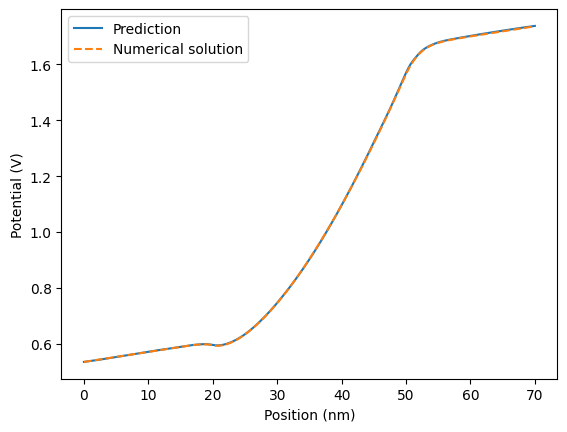

In [130]:
# file_name = "DD_full_data_Lsd_20.dat"
# train_data = np.loadtxt(file_name)

# Load loss trajectory
with open('loss_traj_1D_Poi_Cont_test-dhseo-final.pkl', 'rb') as f:
    loaded_loss_traj = pickle.load(f)

# Load parameters
with open('params_1D_Poi_Cont_test-dhseo-final.pkl', 'rb') as f:
    loaded_params = pickle.load(f)


for Lch in [30]:
    L = Lch + 2 * Lsd
    for Nsd  in [1e-2]: 
        for Nch in [1e-4]:
            for Vd in [1.2]:
                interface_idx = round(Lsd / (dx * L))
                
                           
                Vd_input = jnp.linspace(0, Vd, 501)

                # for i in range(interface_idx+1, 501 - interface_idx):
                #     Nd = Nd.at[i].set(Nch/Nsd_max)
                
                Nd = Nsd * np.ones((501, 1))                
                Nd[interface_idx+1:501 - interface_idx] = Nch # Nch
                
                Nd = jnp.array(  ( np.log(Nd) - np.log(Nsd_min) )  / (np.log(Nsd_max) - np.log(Nsd_min))  )
            
                # Get training data 
                curr_data = train_data[(train_data[:, 0] == Nsd * 1e21) & (train_data[:, 1] == Nch * 1e21) & \
                        (train_data[:, 2] == Lch ) & (train_data[:, 3] == Vd)]
                
                test_pot = curr_data[0, 5:506]
                test_charge = curr_data[0, 506:1008] * 1e-27
                
                pred = jax.vmap(pinn, in_axes=(None, 0, 0, 0))(loaded_params, x, Nd, Vd_input)

                _, ax0 = plt.subplots(1, 1)
                ax0.plot(x * L, pred[:, 0], label="Prediction")
                ax0.plot(x * L, test_pot, "--", label="Numerical solution")
                ax0.set(xlabel='Position (nm)', ylabel='Potential (V)')
                
                             
                # ax0.semilogy(x * L, np.exp(pred[:, 1]) * 1e21, label="Prediction")
                # ax0.plot(x * L, test_charge * 1e21, "--", label="Numerical solution")
                # ax0.set(xlabel='Position (nm)', ylabel='Charge (/cm^3)')
                
                ax0.legend()
                

ValueError: x and y must have same first dimension, but have shapes (1,) and (120,)

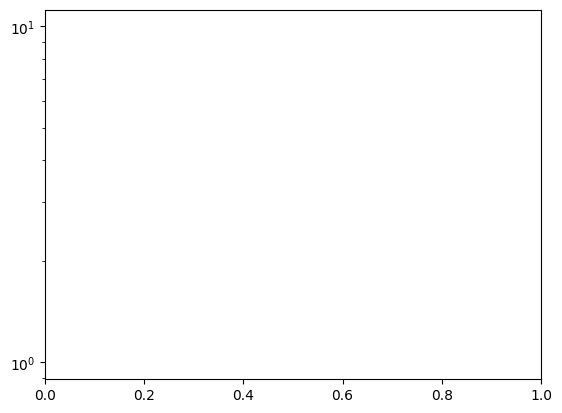

In [45]:
# Load loss trajectory
with open('loss_traj_1D_Poi_Cont_test-dhseo-final.pkl', 'rb') as f:
    loaded_loss_traj = pickle.load(f)

it = np.linspace(0, 120, 1) * 20000 / 120 
plt.semilogy(it, loaded_loss_traj)

0.0013228978019575366

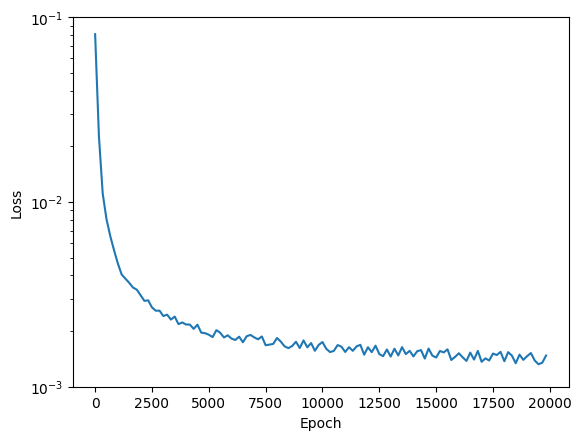

In [67]:
# Load loss trajectory
with open('loss_traj_1D_Poi_Cont_test-dhseo-final.pkl', 'rb') as f:
    loaded_loss_traj = pickle.load(f)

_, ax0 = plt.subplots(1, 1)
it = np.array(range(120)) * 20000 / 120 
ax0.semilogy(it, loaded_loss_traj)
ax0.set(xlabel='Epoch', ylabel='Loss')
ax0.set_ylim(1e-3, 1e-1)
plt.show
np.array(loaded_loss_traj).min()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [143]:
# Initialize parameters
ELEM_Q = 1.602e-19
BOLTZ = 1.380662e-23
EPS_0 = 8.864-12 * 1e-9
EPS_S = 11.7 * EPS_0
T = 300
KT_Q = BOLTZ * T / ELEM_Q
NI = 1e10 * 1e-21

file_name = "DD_full_data_Lsd_20.dat"
train_data = np.loadtxt(file_name)

# Load loss trajectory
with open('loss_traj_1D_Poi_Cont_test-dhseo-final.pkl', 'rb') as f:
    loaded_loss_traj = pickle.load(f)

# Load parameters
with open('params_1D_Poi_Cont_test-dhseo-final.pkl', 'rb') as f:
    loaded_params = pickle.load(f)

Lsd = 20


L2_loss = np.zeros((2))
Linf_loss = np.zeros((2))
Linf_loss_temp = np.zeros((2))

Vd_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2]
Vd_train = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
Vd_inter = [0.05, 0.1, 0.15, 0.25, 0.3, 0.35, 0.45, 0.5, 0.55, 0.65, 0.7, 0.75, 0.85, 0.9, 0.95]
Vd_extra = [1.05, 1.1, 1.15, 1.2 ]

Id = []
Id_pred = []
for Lch in [30]:
    L = Lch + 2 * Lsd
    for Nsd  in [1e-2]: 
        for Nch in [1e-4]:
            for Vd in Vd_list:
                interface_idx = round(Lsd / (dx * L))
                
                Vd_input = jnp.linspace(0, Vd, 501)


                Nd = Nsd * np.ones((501, 1))                
                Nd[interface_idx+1:501 - interface_idx] = Nch # Nch
                
                Nd = jnp.array(  ( np.log(Nd) - np.log(Nsd_min) )  / (np.log(Nsd_max) - np.log(Nsd_min))  )
            
                # Get training data 
                curr_data = train_data[(train_data[:, 0] == Nsd * 1e21) & (train_data[:, 1] == Nch * 1e21) & \
                        (train_data[:, 2] == Lch ) & (train_data[:, 3] == Vd)]
                
                test_pot = curr_data[0, 5:506]
                test_charge = curr_data[0, 506:1008] * 1e-27
                
                pred = jax.vmap(pinn, in_axes=(None, 0, 0, 0))(loaded_params, x, Nd, Vd_input)        

                L2_loss[0] += (((pred[:, 0] - test_pot)**2).sum() / ((test_pot)**2).sum())**0.5 
                L2_loss[1] += (((np.exp(pred[:, 1]) - test_charge)**2).sum() / ((test_charge)**2).sum())**0.5 
                
                Linf_loss_temp[0] = (np.abs(pred[:, 0] - test_pot)).max()
                Linf_loss_temp[1] = (np.abs(np.exp(pred[:, 1]) - test_charge)).max() / Nsd_max
                
                Id.append(curr_data[0, 4])

                # Id_pred_temp = ELEM_Q * 1417 * ((test_charge[-1] *1e27 + test_charge[-2] *1e27)/2 * (test_pot[-1] - test_pot[-2])/(dx * L * 1e-9)  - KT_Q * (test_charge[-1] *1e27 - test_charge[-2] *1e27)/(dx * L* 1e-9)) * 1e-8
                
                Id_pred_temp = ELEM_Q * 1417 * ((np.exp(pred[-1, 1])*1e27 + np.exp(pred[-2, 1])*1e27)/2 * (pred[-1, 0] - pred[-2, 0])/(dx * L * 1e-9 )  - KT_Q * (np.exp(pred[-1, 1])*1e27 - np.exp(pred[-2, 1])*1e27)/(dx * L* 1e-9)) * 1e-8
                
                Id_pred.append(Id_pred_temp)

                if Linf_loss_temp[0] > Linf_loss[0]:
                    Linf_loss[0] = Linf_loss_temp[0]

                if Linf_loss_temp[1] > Linf_loss[1]:
                    Linf_loss[1] = Linf_loss_temp[1]
                    
L2_loss /= len(Vd_list)

print(f"pot L2 loss : {L2_loss[0]:.5e}, pot Linf loss : {Linf_loss[0]:.5e}, charge L2 loss : {L2_loss[1]:.5e}, charge Linf loss : {Linf_loss[1]:.5e}")



pot L2 loss : 2.79112e-04, pot Linf loss : 5.26807e-03, charge L2 loss : 8.55014e-04, charge Linf loss : 1.35800e-02


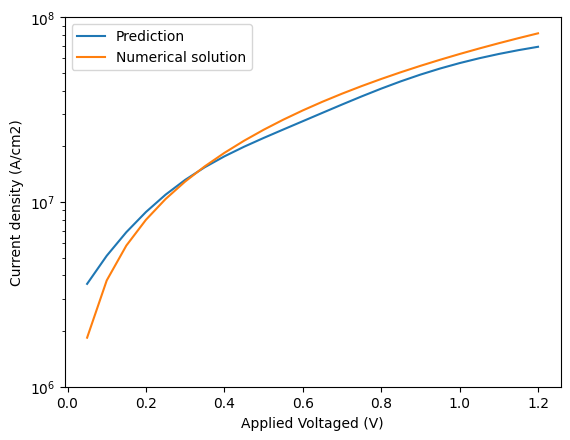

In [152]:

_, ax0 = plt.subplots(1, 1)
it = np.array(range(120)) * 20000 / 120 
ax0.semilogy(Vd_list[1:], Id_pred[1:], label="Prediction")
ax0.semilogy(Vd_list[1:], Id[1:], label="Numerical solution")
ax0.set(xlabel='Applied Voltaged (V)', ylabel='Current density (A/cm2)')
ax0.set_ylim(1e6, 1e8)
ax0.legend()

In [160]:
((((np.array(Id_pred[1:])- np.array(Id[1:]))**2).sum() / (np.array(Id[1:]))**2).sum())**0.5

17.599123455069517

In [120]:
test_pot[-1]

1.735802